In [37]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [38]:
def load_conversion_results(results_file):
    """Load the conversion results JSON file."""
    with open(results_file, 'r') as f:
        return json.load(f)

results_file = "/data/jane/math_gender/conversion_test/conversion_results/conversion_results_20251215_121544.json"
data = load_conversion_results(results_file)
df = pd.DataFrame(data)

print(f"Loaded {len(df)} conversion results")
print(f"Models: {df['model'].unique().tolist()}")
print(f"Cuisines: {df['cuisine'].unique().tolist()}")
print(f"Conversion directions: {df['conversion_direction'].unique().tolist()}")


Loaded 1072 conversion results
Models: ['gpt-4o', 'qwen-coder', 'llama-4', 'deepseek-r1']
Cuisines: ['chinese', 'spanish', 'greek', 'indian', 'italian', 'mexican', 'cajun_creole', 'southern_us', 'filipino', 'french']
Conversion directions: ['oz_to_ml', 'ml_to_oz']


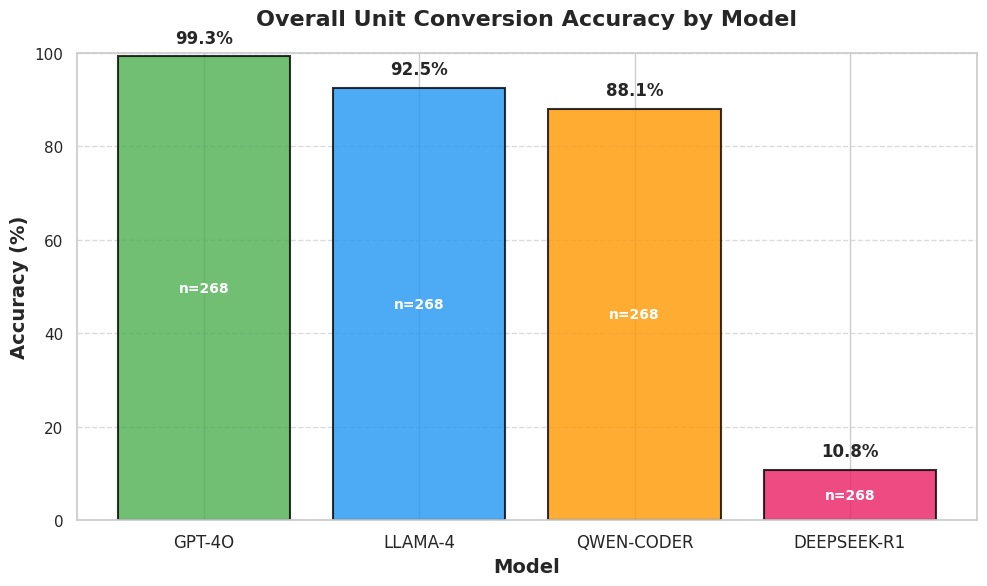

In [39]:
def plot_overall_accuracy(df, output_dir="conversion_results/plots"):
    """Create bar plot of overall accuracy by model."""
    
    # Calculate accuracy by model
    model_accuracy = df.groupby('model')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
    model_accuracy.columns = ['model', 'correct', 'total', 'accuracy']
    model_accuracy['accuracy'] = model_accuracy['accuracy'] * 100
    model_accuracy = model_accuracy.sort_values('accuracy', ascending=False)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['#4CAF50', '#2196F3', '#FF9800', '#E91E63']
    bars = ax.bar(range(len(model_accuracy)), model_accuracy['accuracy'], 
                  color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Customize
    ax.set_xlabel('Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Overall Unit Conversion Accuracy by Model', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(range(len(model_accuracy)))
    ax.set_xticklabels([m.upper() for m in model_accuracy['model']], fontsize=12)
    ax.set_ylim(0, 100)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add value labels and counts
    for i, (idx, row) in enumerate(model_accuracy.iterrows()):
        height = row['accuracy']
        ax.text(i, height + 2, f'{height:.1f}%', 
                ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.text(i, height/2, f'n={int(row["total"])}', 
                ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    
    plt.tight_layout()
    
    # # Save
    # os.makedirs(output_dir, exist_ok=True)
    # output_file = os.path.join(output_dir, 'overall_accuracy.png')
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # print(f"Saved: {output_file}")
    
    return fig

overall_fig = plot_overall_accuracy(df)
plt.show()

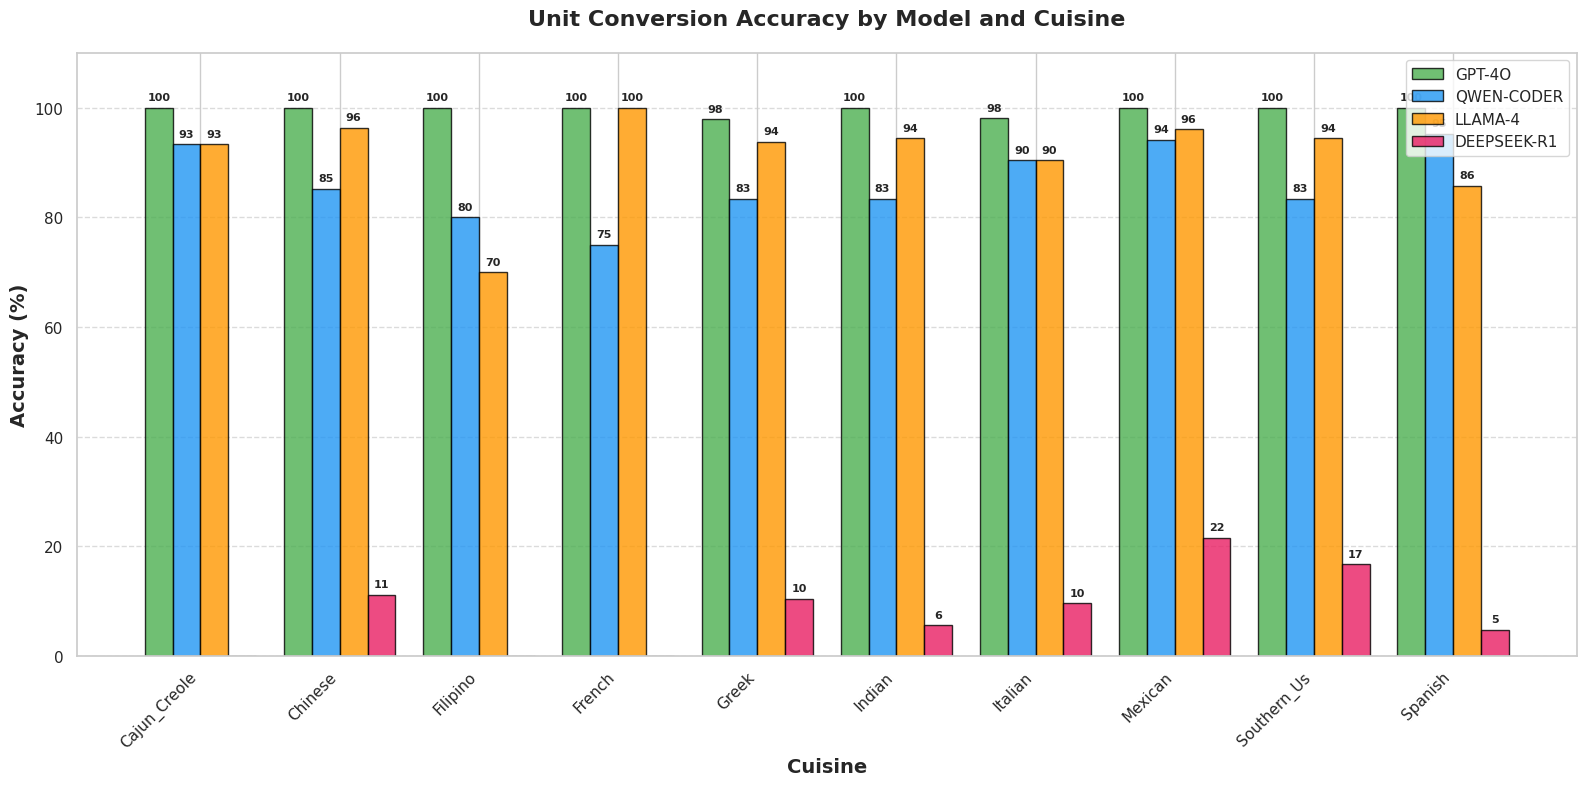

In [40]:
def plot_accuracy_by_cuisine(df, output_dir="conversion_results/plots"):
    """Create grouped bar plot of accuracy by model and cuisine."""
    
    # Calculate accuracy by model and cuisine
    cuisine_accuracy = df.groupby(['model', 'cuisine'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
    cuisine_accuracy.columns = ['model', 'cuisine', 'correct', 'total', 'accuracy']
    cuisine_accuracy['accuracy'] = cuisine_accuracy['accuracy'] * 100
    
    # Get unique cuisines and models
    cuisines = sorted(df['cuisine'].unique())
    models = df['model'].unique()
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    x = np.arange(len(cuisines))
    width = 0.2
    colors = ['#4CAF50', '#2196F3', '#FF9800', '#E91E63']
    
    for i, model in enumerate(models):
        model_data = cuisine_accuracy[cuisine_accuracy['model'] == model]
        # Ensure all cuisines are represented
        accuracies = []
        for cuisine in cuisines:
            cuisine_row = model_data[model_data['cuisine'] == cuisine]
            if len(cuisine_row) > 0:
                accuracies.append(cuisine_row['accuracy'].iloc[0])
            else:
                accuracies.append(0)
        
        offset = width * (i - len(models)/2 + 0.5)
        bars = ax.bar(x + offset, accuracies, width, 
                     label=model.upper(), color=colors[i % len(colors)],
                     edgecolor='black', linewidth=1, alpha=0.8)
        
        # Add value labels
        for j, (bar, acc) in enumerate(zip(bars, accuracies)):
            if acc > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{acc:.0f}', ha='center', va='bottom', 
                       fontsize=8, fontweight='bold')
    
    # Customize
    ax.set_xlabel('Cuisine', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Unit Conversion Accuracy by Model and Cuisine', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([c.title() for c in cuisines], rotation=45, ha='right')
    ax.set_ylim(0, 110)
    ax.legend(loc='upper right', fontsize=11)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    
    # # Save
    # output_file = os.path.join(output_dir, 'accuracy_by_cuisine.png')
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # print(f"Saved: {output_file}")
    
    return fig

cuisine_fig = plot_accuracy_by_cuisine(df)
plt.show()

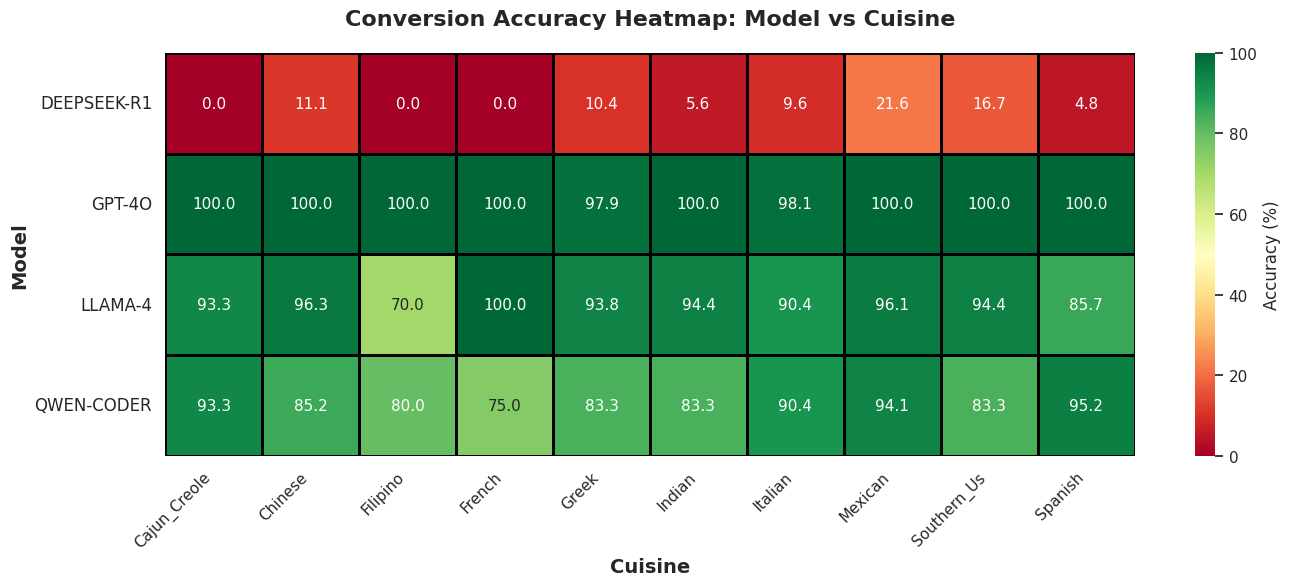

In [41]:
def plot_accuracy_heatmap(df, output_dir="conversion_results/plots"):
    """Create heatmap showing accuracy by model and cuisine."""
    
    # Calculate accuracy by model and cuisine
    pivot_data = df.groupby(['model', 'cuisine'])['is_correct'].mean().reset_index()
    pivot_data['accuracy'] = pivot_data['is_correct'] * 100
    
    # Pivot to create matrix
    heatmap_data = pivot_data.pivot(index='model', columns='cuisine', values='accuracy')
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', 
                vmin=0, vmax=100, cbar_kws={'label': 'Accuracy (%)'},
                linewidths=1, linecolor='black', ax=ax)
    
    # Customize
    ax.set_xlabel('Cuisine', fontsize=14, fontweight='bold')
    ax.set_ylabel('Model', fontsize=14, fontweight='bold')
    ax.set_title('Conversion Accuracy Heatmap: Model vs Cuisine', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_yticklabels([label.get_text().upper() for label in ax.get_yticklabels()], 
                       rotation=0, fontsize=12)
    ax.set_xticklabels([label.get_text().title() for label in ax.get_xticklabels()], 
                       rotation=45, ha='right', fontsize=11)
    
    plt.tight_layout()
    
    # Save
    # output_file = os.path.join(output_dir, 'accuracy_heatmap.png')
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # print(f"Saved: {output_file}")
    
    return fig

heatmap_fig = plot_accuracy_heatmap(df)
plt.show()

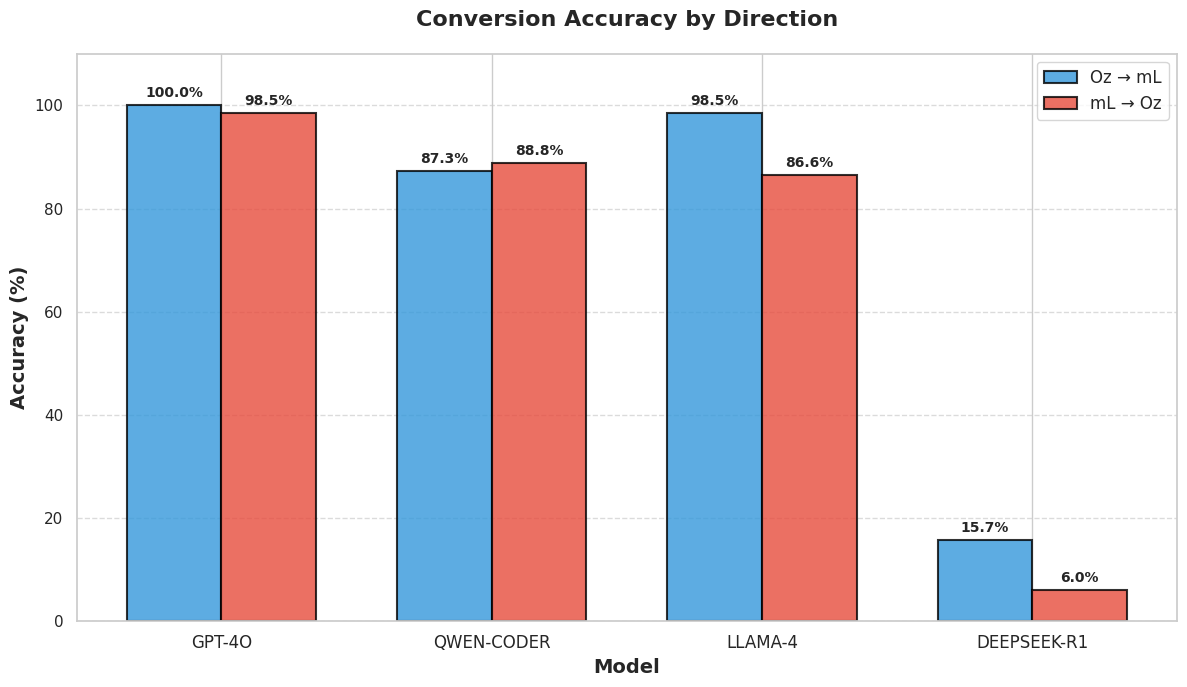

In [42]:
def plot_accuracy_by_direction(df, output_dir="conversion_results/plots"):
    """Create plot comparing oz->ml vs ml->oz accuracy."""
    
    # Calculate accuracy by model and direction
    direction_accuracy = df.groupby(['model', 'conversion_direction'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
    direction_accuracy.columns = ['model', 'direction', 'correct', 'total', 'accuracy']
    direction_accuracy['accuracy'] = direction_accuracy['accuracy'] * 100
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    models = df['model'].unique()
    directions = ['oz_to_ml', 'ml_to_oz']
    direction_labels = ['Oz → mL', 'mL → Oz']
    
    x = np.arange(len(models))
    width = 0.35
    
    colors = ['#3498db', '#e74c3c']
    
    for i, (direction, label) in enumerate(zip(directions, direction_labels)):
        direction_data = direction_accuracy[direction_accuracy['direction'] == direction]
        accuracies = []
        for model in models:
            model_row = direction_data[direction_data['model'] == model]
            if len(model_row) > 0:
                accuracies.append(model_row['accuracy'].iloc[0])
            else:
                accuracies.append(0)
        
        offset = width * (i - 0.5)
        bars = ax.bar(x + offset, accuracies, width, 
                     label=label, color=colors[i],
                     edgecolor='black', linewidth=1.5, alpha=0.8)
        
        # Add value labels
        for j, (bar, acc) in enumerate(zip(bars, accuracies)):
            if acc > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{acc:.1f}%', ha='center', va='bottom', 
                       fontsize=10, fontweight='bold')
    
    # Customize
    ax.set_xlabel('Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Conversion Accuracy by Direction', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in models], fontsize=12)
    ax.set_ylim(0, 110)
    ax.legend(fontsize=12, loc='upper right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    
    # Save
    # output_file = os.path.join(output_dir, 'accuracy_by_direction.png')
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # print(f"Saved: {output_file}")
    
    return fig

direction_fig = plot_accuracy_by_direction(df)
plt.show()

In [43]:
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

# Overall by model
print("\nOverall Accuracy by Model:")
overall_stats = df.groupby('model')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
overall_stats.columns = ['Model', 'Correct', 'Total', 'Accuracy']
overall_stats['Accuracy'] = overall_stats['Accuracy'] * 100
overall_stats = overall_stats.sort_values('Accuracy', ascending=False)
print(overall_stats.to_string(index=False))

# By cuisine
print("\n\nAccuracy by Cuisine (averaged across models):")
cuisine_stats = df.groupby('cuisine')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
cuisine_stats.columns = ['Cuisine', 'Correct', 'Total', 'Accuracy']
cuisine_stats['Accuracy'] = cuisine_stats['Accuracy'] * 100
cuisine_stats = cuisine_stats.sort_values('Accuracy', ascending=False)
print(cuisine_stats.to_string(index=False))

# By direction
print("\n\nAccuracy by Conversion Direction (averaged across models):")
direction_stats = df.groupby('conversion_direction')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
direction_stats.columns = ['Direction', 'Correct', 'Total', 'Accuracy']
direction_stats['Accuracy'] = direction_stats['Accuracy'] * 100
print(direction_stats.to_string(index=False))

print("="*80)


STATISTICAL SUMMARY

Overall Accuracy by Model:
      Model  Correct  Total  Accuracy
     gpt-4o      266    268 99.253731
    llama-4      248    268 92.537313
 qwen-coder      236    268 88.059701
deepseek-r1       29    268 10.820896


Accuracy by Cuisine (averaged across models):
     Cuisine  Correct  Total  Accuracy
     mexican      159    204 77.941176
 southern_us       53     72 73.611111
     chinese       79    108 73.148148
     italian      150    208 72.115385
cajun_creole       43     60 71.666667
     spanish       60     84 71.428571
       greek      137    192 71.354167
      indian       51     72 70.833333
      french       22     32 68.750000
    filipino       25     40 62.500000


Accuracy by Conversion Direction (averaged across models):
Direction  Correct  Total  Accuracy
 ml_to_oz      375    536 69.962687
 oz_to_ml      404    536 75.373134


In [44]:
def analyze_cuisine_bias(df):
    """Analyze if models show bias toward certain cuisines."""
    
    # Get overall accuracy per model
    model_overall = df.groupby('model')['is_correct'].mean()
    
    # Get accuracy per model per cuisine
    model_cuisine = df.groupby(['model', 'cuisine'])['is_correct'].mean().reset_index()
    
    # Calculate deviation from overall
    bias_data = []
    for model in df['model'].unique():
        overall_acc = model_overall[model]
        model_data = model_cuisine[model_cuisine['model'] == model]
        
        for _, row in model_data.iterrows():
            cuisine = row['cuisine']
            cuisine_acc = row['is_correct']
            deviation = (cuisine_acc - overall_acc) * 100
            
            bias_data.append({
                'model': model,
                'cuisine': cuisine,
                'accuracy': cuisine_acc * 100,
                'overall_accuracy': overall_acc * 100,
                'deviation': deviation
            })
    
    bias_df = pd.DataFrame(bias_data)
    
    print("\n" + "="*80)
    print("CUISINE BIAS ANALYSIS")
    print("="*80)
    print("\nDeviation from overall accuracy (positive = better on this cuisine):")
    
    for model in df['model'].unique():
        model_bias = bias_df[bias_df['model'] == model].sort_values('deviation', ascending=False)
        print(f"\n{model.upper()}:")
        print(model_bias[['cuisine', 'accuracy', 'deviation']].to_string(index=False))
    
    return bias_df

bias_df = analyze_cuisine_bias(df)


CUISINE BIAS ANALYSIS

Deviation from overall accuracy (positive = better on this cuisine):

GPT-4O:
     cuisine   accuracy  deviation
cajun_creole 100.000000   0.746269
     chinese 100.000000   0.746269
    filipino 100.000000   0.746269
      french 100.000000   0.746269
      indian 100.000000   0.746269
     mexican 100.000000   0.746269
     spanish 100.000000   0.746269
 southern_us 100.000000   0.746269
     italian  98.076923  -1.176808
       greek  97.916667  -1.337065

QWEN-CODER:
     cuisine  accuracy  deviation
     spanish 95.238095   7.178394
     mexican 94.117647   6.057946
cajun_creole 93.333333   5.273632
     italian 90.384615   2.324914
     chinese 85.185185  -2.874516
      indian 83.333333  -4.726368
       greek 83.333333  -4.726368
 southern_us 83.333333  -4.726368
    filipino 80.000000  -8.059701
      french 75.000000 -13.059701

LLAMA-4:
     cuisine   accuracy  deviation
      french 100.000000   7.462687
     chinese  96.296296   3.758983
     mexica

In [45]:
df['len_answer'] = df['model_answer_raw'].apply(lambda x: len(x))
df[df['model']== 'deepseek-r1'].groupby('cuisine').mean(numeric_only = True)

,random_value,correct_answer,model_answer,is_correct,len_answer
cuisine,,,,,
cajun_creole,5533.526667,48237.623800,3.586510e+03,0.000000,5334.666667
chinese,4471.774074,72217.131215,3.837869e+04,0.111111,5434.111111
filipino,4940.212000,42217.281120,2.957601e+06,0.000000,5288.600000
french,6982.273750,78753.378000,9.323755e+02,0.000000,5390.250000
greek,4902.725000,87654.468002,6.975033e+04,0.104167,5432.062500
indian,5277.380556,87198.202250,7.435409e+04,0.055556,5384.722222
italian,4739.128846,71703.418223,2.694444e+09,0.096154,5335.557692
mexican,4921.129216,81086.241869,8.185262e+04,0.215686,5478.392157
southern_us,5039.608889,86952.465983,1.209029e+04,0.166667,5216.000000
